In [ ]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys

# --- PyTorch and Sklearn Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score

# --- TensorFlow for Data Loading ONLY ---
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory 
DATA_DIR = Path("../../data/raw/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# Import necessary functions from other notebooks/modules
sys.path.append('../../src')

# --- CORRECTED TFRecord PARSING FUNCTION ---
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    Instead of assuming string, we now correctly specify a 64x64 float tensor.
    """
    feature_description = {}
    
    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]
    
    # CRITICAL FIX: We now tell TensorFlow to expect a 64x64 array of floats.
    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)
    
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

# NOTE: The decode_feature function is no longer needed and has been removed.

print("\n✅ Setup complete - data loading functions are now corrected!")

📁 Data directory: ..\data\raw\ndws_western_dataset
📂 Directory exists: True

✅ Setup complete - data loading functions are now corrected!


In [2]:
# VISUALIZATION FUNCTIONS (PYTORCH VERSION)
def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4):
    """Visualize fire prediction results from a PyTorch model"""
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]
    
    with torch.no_grad():
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        # Transpose back to (N, H, W, C) for visualization with Matplotlib
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {np.sum(y_test_subset > 0.1)}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {np.sum(predictions > 0.5)}")
    print(f"📈 Average prediction confidence: {np.mean(predictions):.4f}")

print("✅ PyTorch visualization function defined with corrected t+1 labels!")

✅ PyTorch visualization function defined with corrected t+1 labels!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        # Load all daily snapshots into one list
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC ---
        spatial_inputs, spatial_targets = [], []
        # Total window size = num_timesteps (past env) + 1 (current day) + 1 (target day)
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            # Define the time windows
            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps] # t-4 to t-1
            current_day_sample = all_samples_flat[i + self.num_timesteps]              # day 't'
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]           # day 't+1'

            # --- Assemble the Input Tensor (X) ---
            input_features = []
            
            # 1. Add the fire mask from the CURRENT day (t)
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))

            # 2. Add environmental features from the PAST days (t-4 to t-1)
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            
            # 3. Add environmental features from the CURRENT day (t)
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# PYTORCH U-NET ARCHITECTURE, LOSS FUNCTION, AND NEW K-FOLD CROSS-VALIDATION TRAINING FUNCTION

# --- 1. LOSS FUNCTION: BCE + Dice ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- 2. U-NET MODEL DEFINITION IN PYTORCH ---
class FireUNetPyTorch(nn.Module):
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(FireUNetPyTorch, self).__init__()
        def _conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True))
        
        self.enc1 = _conv_block(in_channels, filters_base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = _conv_block(filters_base, filters_base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = _conv_block(filters_base*2, filters_base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = _conv_block(filters_base*4, filters_base*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = _conv_block(filters_base*8, filters_base*16)
        self.upconv4 = nn.ConvTranspose2d(filters_base*16, filters_base*8, 2, stride=2)
        self.dec4 = _conv_block(filters_base*16, filters_base*8)
        self.upconv3 = nn.ConvTranspose2d(filters_base*8, filters_base*4, 2, stride=2)
        self.dec3 = _conv_block(filters_base*8, filters_base*4)
        self.upconv2 = nn.ConvTranspose2d(filters_base*4, filters_base*2, 2, stride=2)
        self.dec2 = _conv_block(filters_base*4, filters_base*2)
        self.upconv1 = nn.ConvTranspose2d(filters_base*2, filters_base, 2, stride=2)
        self.dec1 = _conv_block(filters_base*2, filters_base)
        self.out_conv = nn.Conv2d(filters_base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))

# --- 3. NEW TRAINING FUNCTION WITH K-FOLD AND AVERAGE PRECISION ---
def train_fire_unet_cv_pytorch(X_spatial, y_spatial, n_splits=5, epochs=20, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 INITIATING U-NET TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spatial)):
        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        # (Data preparation code is the same as before)
        X_train, X_val = X_spatial[train_idx], X_spatial[val_idx]
        y_train, y_val = y_spatial[train_idx], y_spatial[val_idx]

        X_train_t = np.transpose(X_train, (0, 3, 1, 2))
        X_val_t = np.transpose(X_val, (0, 3, 1, 2))
        y_train_t = (np.transpose(y_train, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        y_val_t = (np.transpose(y_val, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_train_norm = (X_train_t - channel_means) / channel_stds
        X_val_norm = (X_val_t - channel_means) / channel_stds
        
        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_norm), torch.from_numpy(y_train_t)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_norm), torch.from_numpy(y_val_t)), batch_size=batch_size, shuffle=False)
        
        model = FireUNetPyTorch(in_channels=X_train_norm.shape[1], out_channels=1).to(device)
        criterion = BCEDiceLoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        # --- UPDATED TRAINING LOOP WITH EPOCH PROGRESS ---
        print(f"🔥 STARTING TRAINING for {epochs} epochs...")
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            # Print average loss for the epoch
            epoch_loss = running_loss / len(train_loader)
            print(f"  Epoch {epoch + 1}/{epochs} - Training Loss: {epoch_loss:.4f}")
        
        # (Evaluation part is the same as before)
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device))
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.numpy().flatten())
        
        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        fold_ap_scores.append(ap_score)
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    # --- FINAL SUMMARY AND MODEL SAVING ---
    print("\n\n📊 CROSS-VALIDATION SUMMARY")
    print("=" * 60)
    print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    
    # --- ADDED: SAVE THE FINAL MODEL ---
    if last_model:
        model_save_path = "final_fire_unet.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from the last fold saved to '{model_save_path}'")
    
    return last_model, fold_ap_scores

🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...
📁 Found 54 TFRecord files
  ...Loaded 20097 total individual samples.

✅ COMBINED DATA LOADING COMPLETE
📊 Spatial Input Shape: (500, 64, 64, 106)
📊 Spatial Target Shape: (500, 64, 64, 1)

--- Training COMBINED Model ---
🚀 INITIATING U-NET TRAINING ON cpu WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING for 15 epochs...
  Epoch 1/15 - Training Loss: 0.6619
  Epoch 2/15 - Training Loss: 0.5290
  Epoch 3/15 - Training Loss: 0.5104
  Epoch 4/15 - Training Loss: 0.4980
  Epoch 5/15 - Training Loss: 0.4853
  Epoch 6/15 - Training Loss: 0.4802
  Epoch 7/15 - Training Loss: 0.4711
  Epoch 8/15 - Training Loss: 0.4657
  Epoch 9/15 - Training Loss: 0.4586
  Epoch 10/15 - Training Loss: 0.4566
  Epoch 11/15 - Training Loss: 0.4511
  Epoch 12/15 - Training Loss: 0.4488
  Epoch 13/15 - Training Loss: 0.4492
  Epoch 14/15 - Training Loss: 0.4470
  Epoch 15/15 - Tr

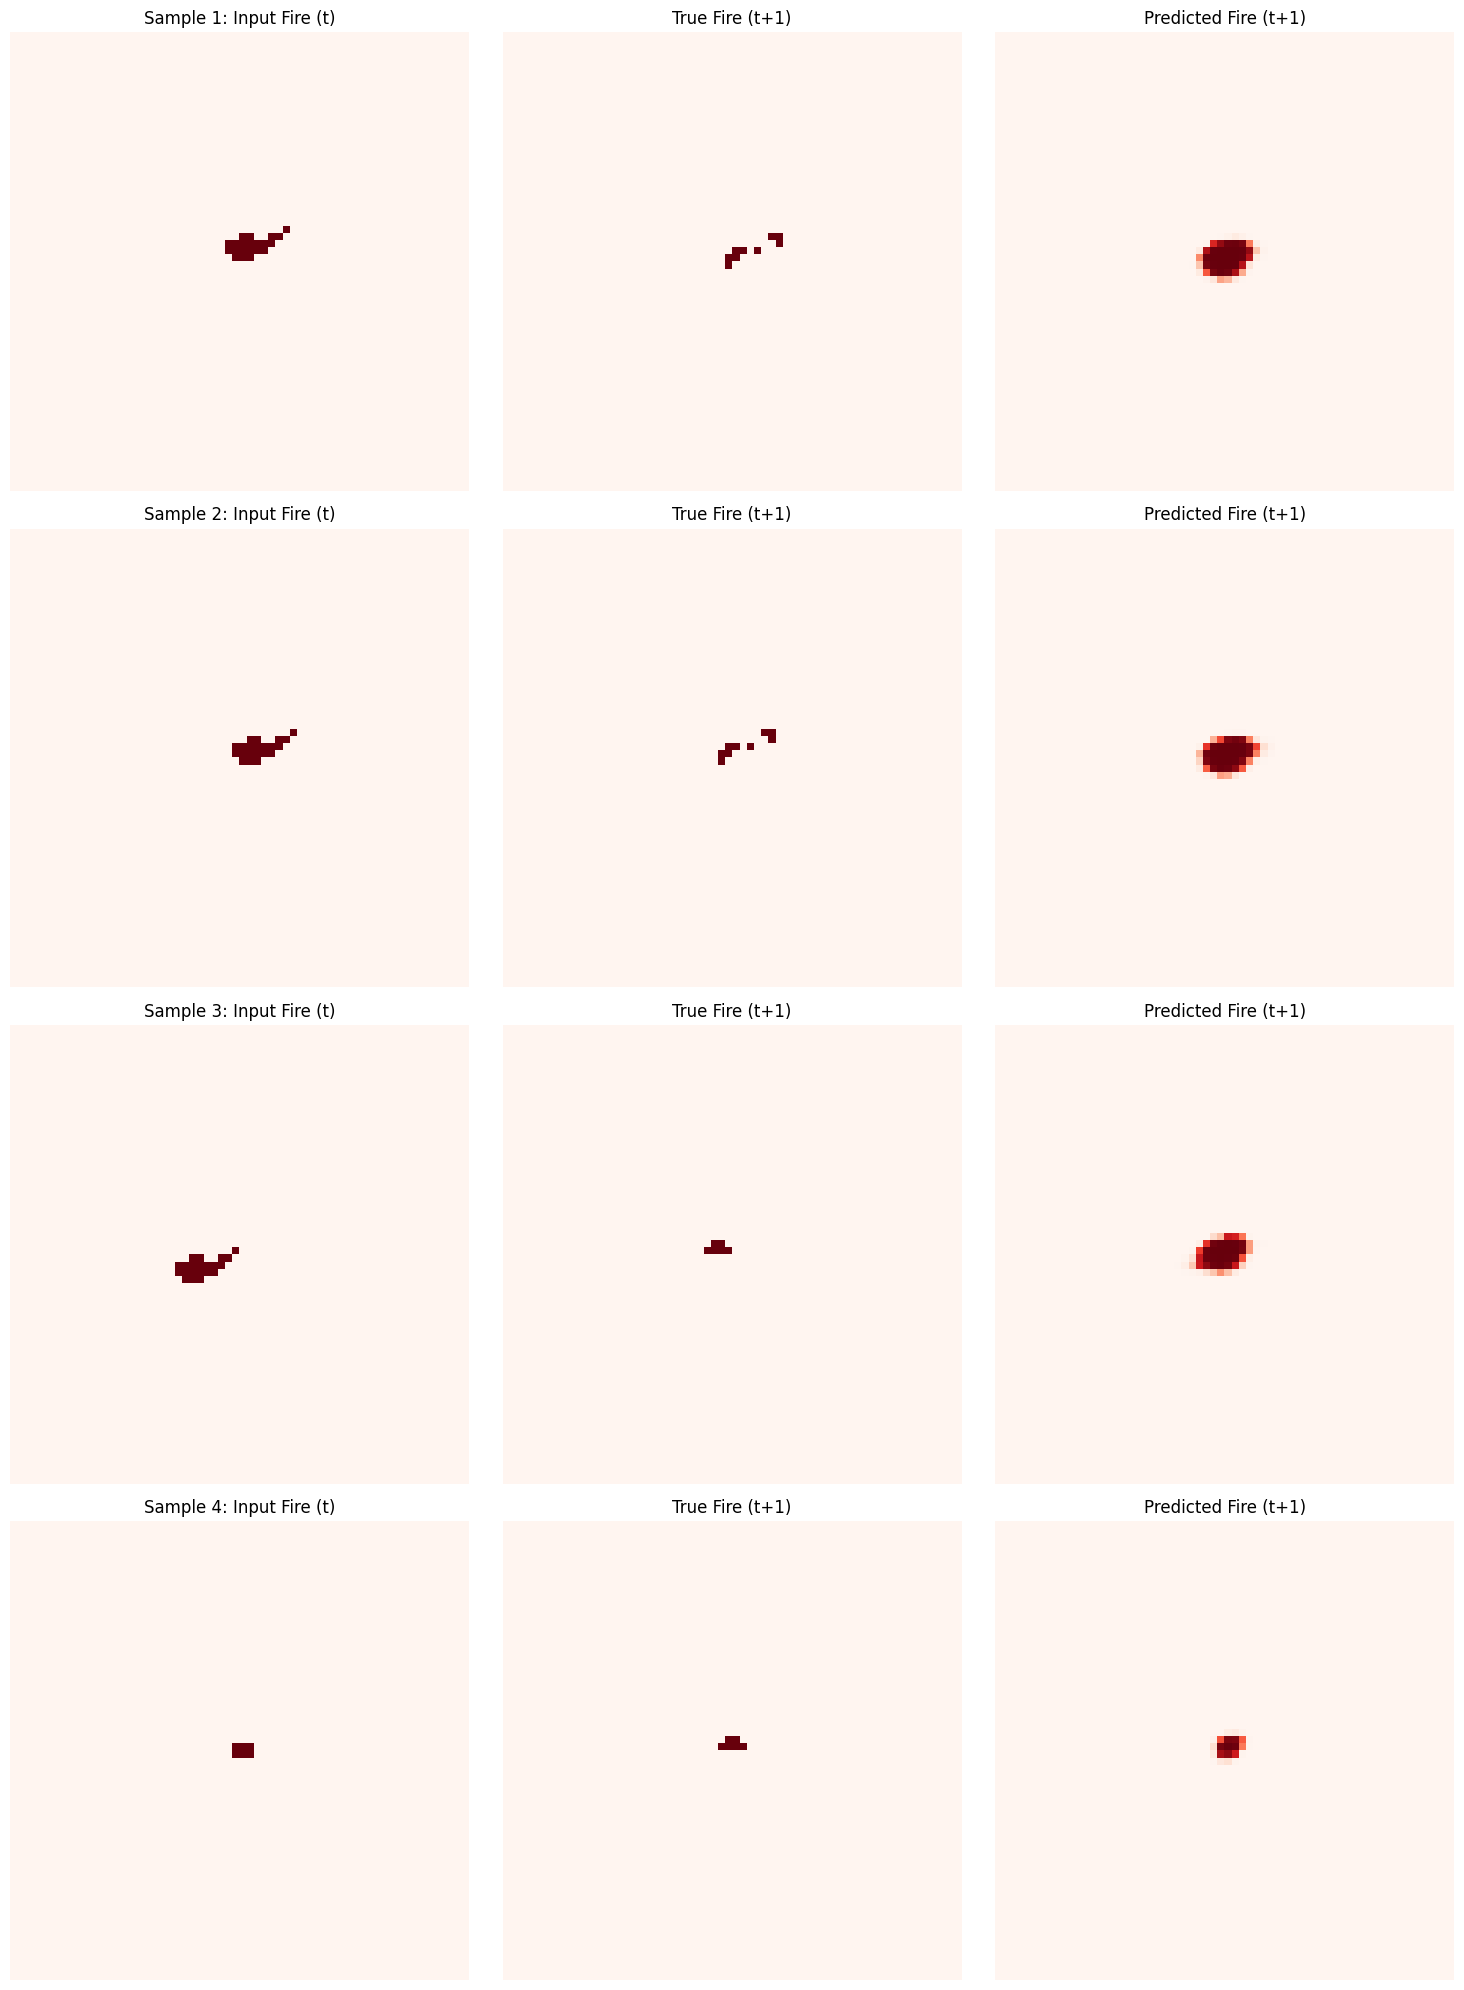


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 30
🎯 Predicted fire pixels (threshold > 0.5): 99
📈 Average prediction confidence: 0.0062


In [5]:
# --- EXECUTION FOR THE DEFINITIVE COMBINED MODEL ---

# 1. Load data using the CombinedFireDataProcessor
combined_processor = CombinedFireDataProcessor(num_timesteps=4)
X_spatial_combined, y_spatial_combined = combined_processor.load_raw_spatial_data(max_sequences=500)

# 2. Train the U-Net model with the combined data
final_model_combined = None 
cv_results_combined = []

if X_spatial_combined is not None:
    print("\n--- Training COMBINED Model ---")
    
    # Reuse the same flexible training function
    final_model_combined, cv_results_combined = train_fire_unet_cv_pytorch(
        X_spatial_combined, y_spatial_combined,
        n_splits=3,
        epochs=15, 
        batch_size=4
    )
    
    # Save the final, best model
    if final_model_combined:
        torch.save(final_model_combined.state_dict(), "combined_fire_unet.pth")
        print("\n💾 Combined model saved to 'combined_fire_unet.pth'")
        print("\n🎉 COMBINED U-NET TRAINING COMPLETED!")
    else:
        print(f"❌ Combined U-Net training failed!")
else:
    print(f"❌ Cannot train Combined U-Net - no data loaded!")
    
# 3. Visualize the results
if final_model_combined is not None:
    print(f"\n🎨 GENERATING VISUALIZATIONS for COMBINED model...")
    
    # Visualization logic remains the same
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    train_indices, val_indices = list(kfold.split(X_spatial_combined))[-1]
    
    X_train_last_fold = X_spatial_combined[train_indices]
    X_test_viz = X_spatial_combined[val_indices]
    y_test_viz = y_spatial_combined[val_indices]
    
    num_viz_samples = min(4, len(X_test_viz))
    if num_viz_samples > 0:
        X_train_t = np.transpose(X_train_last_fold, (0, 3, 1, 2))
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_test_viz_t = np.transpose(X_test_viz[:num_viz_samples], (0, 3, 1, 2))
        X_test_norm_t = (X_test_viz_t - channel_means) / channel_stds
        X_test_norm = np.transpose(X_test_norm_t, (0, 2, 3, 1))

        y_test_binary = (y_test_viz[:num_viz_samples] > 0.1).astype(np.float32)
        
        visualize_fire_predictions_pytorch(
            final_model_combined, X_test_norm, y_test_binary, num_samples=num_viz_samples
        )
    else:
        print("Not enough validation samples to visualize.")
else:
    print(f"\n⚠️ Combined model not available for evaluation.")